In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.3 MB/s eta 0:00:00


In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-11-03 07:18:37--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-11-03 07:18:37--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  78.1MB/s    in 0.2s    

2023-11-03 07:18:38 (78.1 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-11-03 07:26:37--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-11-03 07:26:38--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   786KB/s    in 0.5s    



PROBLEM

The complexity of Transformers is mainly due to a pipeline
of encoders, each of which contains a multi-head
self-attention layer. The self-attention operation
scales quadratically with the input sequence length which is a bottleneck especially for long-sequence data. MOst classification and similarity tasks in NLP use the CLS token on top of the encoder layer thus retaining
full-length sequence till the last encoder creates unnecessary complexity.

SOLUTION

[Xin et al](https://arxiv.org/pdf/2203.14380.pdf) showed a mechanism in charge of reducing the sequence length, either by pruning or pooling by removing redundant tokens in the encoder layers through a selection of core-set tokens. Through this process, we obtain a memory reduction in the inference layer.

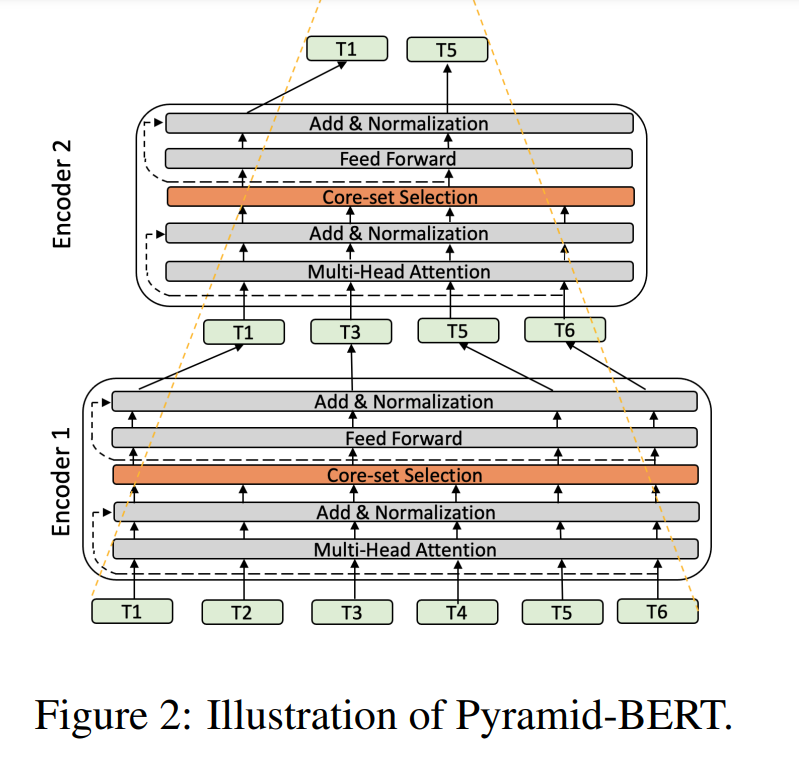

DISCUSSION OF RESULTS

Without further training, i.e using a pre-trained Pyramid Bert model shown below gives a poor performance on the STS benchmark dataset as compared to the pretrained tinyBert model given in section one.

However only 19 token sequences are retained in each encoder layer. The original token sequences is 128. Thus, pyramid Bert is more memory efficient without really compromising the performance of the model.

Blockers/Unexpected behavior:

I could not figure out how to update the attention masks based on the selected token sequences. As a result, I was forced to comment out the masking on the layer which may have impacted the result.
Further work:

Fine-tune pre-trained pyramid Bert Model
Experiment on different prune ratios, and pruning layers
Update attetion masks based on selected token sequences

In [ ]:
class CoreSet(nn.Module):
  """Coreset Based Token Selection"""
  def __init__(self, prune_ratio=0.15,
               iprune_upto=1,
               max_sequence_length=128,
               num_layers=2):
    """
    Construct CoreSet class

    Args:
      prune_ratio: target pruning ratio for sequence lengths
      iprune_upto: index of the layer after which we stop reducing the sequence length
      sequence_length: The maximum sequence length of the sentences
      num_layers: The number of layers in the model

    """
    super(CoreSet, self).__init__()
    self.prune_ratio = prune_ratio
    self.iprune_upto = iprune_upto
    self.sequence_length = max_sequence_length
    self.num_layers = num_layers
    self.seq_length_config = self.calculate_sequence_lengths()

  def forward(self, layer_idx, hidden_states, batch_size=1):
    """
    Token Selection Algorithm for CoreSet Algorithm

    function solves for the core-set which is an NP-Hard problem by
    obtain a 2 × OPT solution of k-Center using a greedy approach

    Args:
      layer_idx : Index of the encoder layer
      hidden_states: input tensor denoting the hidden states of the encoder layer

    Returns:
        tensor of the output
    """
    cls_embedding  = hidden_states[0, 0, :]
    k = self.seq_length_config[layer_idx] #Get the number of tokens to retain for the layer
    S = [cls_embedding] # retain CLS token

    #Implementation of k-center greedy algorithm taking a batch of tokens
    while len(S) < k:
        M = set()

        while len(M) < batch_size:
            max_distance = -1  # Initialize with a negative value
            selected_point = None

            for u in hidden_states[0]:
                if u.tolist() not in [v.tolist() for v in S]:
                # if u not in S:
                    min_dist_to_S = min([torch.norm(u - v) for v in S]) #calculating distance
                    if min_dist_to_S > max_distance:
                        max_distance = min_dist_to_S
                        selected_point = u

            M.add(selected_point)

        S.extend(M)

    return torch.cat([hidden_state.unsqueeze(0) for hidden_state in S], dim=0)

  def calculate_sequence_lengths(self):
    """
    Sequence-length Configuration

     function generates sequence-length configuration by exponentially decaying
     original sequence length
    """
    sequence_lengths = []

    for j in range(self.num_layers):
        length_j = self.sequence_length * (self.prune_ratio ** (min(j+1, self.iprune_upto)/self.iprune_upto))
        sequence_lengths.append(int(length_j))

    return sequence_lengths

In [ ]:
def gelu(x):
    """
    Applies the Gaussian Error Linear Unit (GELU) activation function element-wise to the input tensor.

    Args:
        x (torch.Tensor): The input tensor to which GELU is applied.

    Returns:
        torch.Tensor: returns `x` with the GELU activation applied
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    """Configuration for `Bert`."""

    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.1,
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):
        """
        Constructs `Config` class

        Args:
            vocab_size(int):  Vocabulary size of `inputs_ids` in Bert.
            hidden_size(int): Size of the encoder layers and the pooler layer
            num_hidden_layer(int): Number of hidden layers in the Transformer encoder
            num_attention_heads(int, optional): Number of attention heads for each attention layer in
              the Transformer encoder.
            intermediate_size(int):The size of the intermediate
                layer in the Transformer encoder.
            dropout_prob(float): The dropout probability for hidden layers
            max_position_embedding(int): The maximum number of positional
                embeddings to consider for this model
            type_vocab_size(int):The size of the token type vocabulary passed to the `Bert` model
            initializer_range(float): The range for parameter initialization.
        """

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        """
        Create a Config object from a dictionary input

        Args:
            dict_object (dict): A dictionary containing configuration parameters.

        """

        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      """ Layer Normalisation """

      def __init__(self, hidden_size, variance_epsilon=1e-12):
        """
        Constructor for `LayerNorm`.

        Args:
            hidden_size (int or tuple of ints): The dimensions along which normalization is applied.
            variance_epsilon (float, optional): A small constant to prevent division by zero. Default is 1e-12.
        """

        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        """
        Run layer normalization on the last dimension of the tensor.

        Args:
            x (Tensor): The input tensor to be normalized.

        Returns:
            Tensor: The normalized output tensor.
        """

        u = x.mean(-1, keepdim=True)

        s = (x-u).pow(2).mean(-1, keepdim=True)

        x_norm = (x - u) / torch.sqrt(s + self.variance_epsilon)

        return self.gamma * x_norm + self.beta


class MLP(nn.Module):
      """ Intermediate (feed forward) layer for `Bert` """
      def __init__(self, hidden_size, intermediate_size):
        """
        Constructor for MLP

        Args:
            hidden_size:  Size of the encoder layers.
            intermediate_size: The size of the intermediate
                layer in the Transformer encoder..
        """

        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        """
        Forward pass of the MLP.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor produced by the MLP class.
        """

        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x

In [ ]:
class Layer(nn.Module):
    """ Layer implementation for `Bert` encoder """
    def __init__(self, config):
        """
        Initialize instance of `Layer` class

        Args:
            config: instance of the `Config` class containing configuration settings layer

        """
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)
        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)
        self.coreset = CoreSet()

    def split_heads(self, tensor, num_heads, attention_head_size):
        """
        Transpose the input tensor `tensor` to prepare it for attention score \
         computation in a multi-head attention mechanism

        Args:
            tensor(Tensor): input tensor of shape [batch_size, sequence_length, hidden_size]
            num_heads: number of heads
            attention_size: size of attention head

        Return:
            tensor(Tensor): The reshaped tensor with dimensions
              [batch_size, num_heads, sequence_length, attention_head_size]
        """
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """
        Transpose the input tensor `tensor` from the multi-head attention mechanism to 3D

        Args:
          tensor(Tensor): input tensor tensor with dimensions
                [batch_size, num_heads, sequence_length, attention_head_size]
          num_heads: Number of heads
          attention_head_size: Size of attention layer

        Return:
          tensor(Tensor): The reshaped tensor with dimensions
                 [batch_size, sequence_length, num_heads * attention_head_size].
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        """
        Perform a forward pass of the multi-head self-attention mechanism in a transformer model.

        This function computes the attention scores, and applies self-attention
        to generate to generate context layer.

        Args:
            q (Tensor): The query layer.
            k (Tensor): The key layer
            v (Tensor): The value layer
            attention_mask(Tensor): The attention mask tensor

        Returns: `a` (Tensor) Output context tensor of shape
              [batch_size, sequence_length, hidden_size]
        """

        mask = attention_mask.unsqueeze(1).unsqueeze(2)

        k = k.transpose(-1, -2)


        s = torch.matmul(q, k)

        s = s / math.sqrt(self.attention_head_size)

        mask = mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        adder = (1.0 -  mask) * -10000.0

        # s = s + adder
        p = nn.functional.softmax(s,dim=-1)
        p = self.dropout(p)
        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask, layer_idx):
        """
        Forward pass of the Layer module with self-attention mechanism

        Args:
            x(Tensor): Input tensor
            attention_mask(Tensor): attention_mask of input tensor

        Returns:
            Returns: Tensor of shape [batch_size, seq_length, hidden_size], the final
            hidden layer of the Transformer.
           m(Tensor): Hidden states of model layers
        """
        q, k, v = self.query(x), self.key(x), self.value(x)
        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)
        a = self.ln1(a + x)
        a = self.coreset(layer_idx, a) # Add coreset here
        m = self.mlp(a.unsqueeze(0))
        m = self.dropout(m)
        m = self.ln2(m + a.unsqueeze(0))

        return m

In [ ]:

class PyramidBert(nn.Module):
      """
      Pretrained Pyramid BERT model ("Bidirectional Encoder Representations from Transformers").

      """

      def __init__(self, config_dict):
        """
        Constructor for `Bert`

        Args:
            config_dict(dict): dictionary of configurations for `Config` instance
        """
        super(PyramidBert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        """
        Compute the sentence embeddings using the Bert model

        Args:
            input_ids: Indices of input sequence tokens in the vocabulary.
                float tensor of shape [batch_size, sequence_length]
            attention_mask: float tensor of shape [batch_size, sequence_length]
               Mask to avoid performing attention on padding token indices
            token_type_ids: Segment token indices to indicate
             first and second portions of the inputs. float tensor of shape [batch_size, sequence_length]

        Returns:
        `x`: float Tensor of shape [batch_size, sequence_length, hidden_size] corresponding
            to the final hidden state of `Bert`
        `o`: float tensor of shape [batch_size, hidden_size] corresponding to the
            to the pooler output of the `Bert` model
        """
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)


        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(token_type_ids)

        x = self.dropout(self.ln(x))


        for index, layer in enumerate(self.layers):
            x = layer(x, attention_mask, index)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        """
        Load pretrained bert model
        Args:
          path: Path to pretrained bert model
        Returns:
          Bert instance
        """
        self.load_state_dict(torch.load(path))
        return self

In [ ]:
def load_sts_dataset(file_name):
  """
  Read and load the STS dataset in the required format for tokenization

  Args:
    file_name: The name of the dataset

  Return:
    sts_samples(list): The list of sentences pairs extracted from the dataset
  """
  data = pd.read_csv(file_name,compression='gzip', delimiter='\t',quoting=csv.QUOTE_NONE)
  test_df = data[data['split']== 'test']
  sts_samples = {'test': []}
  for index, row in test_df.iterrows():
        sample = [
            [row['sentence1'], row['sentence2']],
            float(row['score']) / 5
        ]
        sts_samples['test'].append(sample)
  return sts_samples

def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=128):
  """
  Tokenize sentence pairs from the dataset

  Args:
    dataset(list): List of all sentence pairs
    tokenizer: The tokenization model
    max_length: Maximum length of the input sentence sequence

  Returns:
    List of input ids and attention masks from tokenized dataset

  """
  tokenized_dataset = []
  for sentence_pair, label  in dataset:
    tokens = tokenizer(sentence_pair, return_tensors='pt', padding='max_length',
                       max_length=max_length, truncation=True)
    tokenized_sample = {
      'input_ids': tokens['input_ids'],
      'attention_mask': tokens['attention_mask'],
      'labels': label
    }

    tokenized_dataset.append(tokenized_sample)
  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  """
  Load dataset using pytorch's DataLoader class

  Args:
    tokenized_dataset: tokenized dataset which contains list of input ids and
        attention masks
    batch_size: The batch size for loading the data
    shuffle: boolean flag to determine whether to randomize data or not

  Returns:
        instance of pytorch dataloader class
  """
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):
  """
  Compute cosine similarity between two input tensors `a` and `b`

  Args:
      a: 2D float tensor of dimension [batch_size, vector_dim]
      b: 2D float tensor of dimension [batch_size, vector_dim]
  Returns: 2D tensor of the cosine similarity with shape of [batch_size, batch_size]

  """
  dot_product = torch.mm(a,b.T)
  norm_a = torch.linalg.norm(a, dim=1, keepdim=True)
  norm_b = torch.linalg.norm(b, dim=1, keepdim=True)
  cosine_similarity = dot_product/(norm_a * norm_b + 1e-8)
  return cosine_similarity

def eval_loop_optimized(model, eval_dataloader, device):
  """
  Evaluation loop to calculate pearson and spearman correlation coefficients from
  STS benchmark dataset using cosine similarity as distance metric

  Args:
    model: Transformer model to use. E.g `Bert`
    eval_dataloader: Evaluation dataloader which contains dataset of test values in
        STS benchmark dataset
    device: device to run evaluation loop on e.g (cuda, cpu)

  Returns:
       Pearson and spearman correlation coefficients of the sentence pairs
  """
  predicted_similarities = []
  actual_similarities = []
  for batch in tqdm(eval_dataloader):
    sentence1_input_ids = batch['input_ids'][:,0,:].to(device)
    sentence1_attention_mask = batch['attention_mask'][:,0,:].to(device)
    sentence2_input_ids = batch['input_ids'][:,1,:].to(device)
    sentence2_attention_mask = batch['attention_mask'][:,1,:].to(device)
    output_sentence_1 = bert(sentence1_input_ids, sentence1_attention_mask)
    output_sentence_2 = bert(sentence2_input_ids, sentence2_attention_mask)
    score = batch['labels']
    cos_sim  = cosine_sim(output_sentence_1[1],output_sentence_2[1])
    predicted_similarities.extend(cos_sim.detach().numpy().flatten())

    actual_similarities.extend(score)

  eval_pearson_cosine = pearsonr(np.array(actual_similarities),np.array(predicted_similarities)) #calculate pearson's correlation
  eval_spearman_cosine = spearmanr(actual_similarities,predicted_similarities) # calculate spearman's correlation

  return [eval_pearson_cosine[0], eval_spearman_cosine[0],output_sentence_1]

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = PyramidBert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_optimization = eval_loop_optimized(bert, test_dataloader, device)

In [ ]:
print(f'\nPearson correlation: {results_from_optimization[0]:.2f}\nSpearman correlation: {results_from_optimization[1]:.2f}')